## Fake News Binary Classification Problem

In [90]:
# !pip install pyspark
# !pip install requests
# !pip install pandas
# !pip install numpy
# !pip install gc
# !pip install seaborn
# !pip install transformers
# !pip install torch
# !pip install matplotlib
# !pip install datasets
# !pip install sklearn

In [91]:
# import libraries

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

#### Specify the configuration of the Spark application

In [92]:

conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '45G').set('spark.driver.maxResultSize', '10G')


#### Create spark session


In [93]:
import os
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
spark = SparkSession.builder.getOrCreate()

In [94]:
spark

#### Dataset Exploration

In [95]:
# Read the dataset 

news_df = spark.read.csv(path="news.csv",
                         sep=",",
                         inferSchema="true",
                         header="true")


In [96]:
news_df = news_df.orderBy(rand())

In [97]:
news_df = news_df.limit(10000)

In [98]:
news_df.show(15)

+--------------------+--------------------+--------------------+--------------------+-----+
|               title|                text|             subject|                date|label|
+--------------------+--------------------+--------------------+--------------------+-----+
|BREAKING NEWS: VI...|First lady Melani...|            politics|         Jul 7, 2017|    1|
| Former FBI Agent...|Donald Trump is t...|                News|      August 6, 2017|    1|
|Red Cross appeals...|GENEVA (Reuters) ...|           worldnews|   November 7, 2017 |    0|
|Poland's PM desig...|WARSAW (Reuters) ...|           worldnews|   December 8, 2017 |    0|
|WHICH IS IT? DID ...|WATCH: Susan Rice...|           left-news|         Apr 4, 2017|    1|
| Trump Tries To I...|"While Donald Tru...| does a Hillary C...| 2016Featured ima...| News|
|SHE SHOULD NEVER ...|CAN WE JUST STOP ...|            politics|         Dec 4, 2015|    1|
| REPORT: Team Tru...|The entire nation...|                News|   November 16, 

In [99]:
# Types of the features of the dataframe

news_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)
 |-- label: string (nullable = true)



In [100]:
# Shape of the dataset

print("The shape of the dataset is {:d} rows by {:d} columns".format(news_df.count(), len(news_df.columns)))


The shape of the dataset is 10000 rows by 5 columns


In [101]:
# Display values of the target

news_df.select("label").show(100)

+-------+
|  label|
+-------+
|      1|
|      1|
|      0|
|      0|
|      1|
|   News|
|      1|
|      1|
|      0|
|      0|
|      0|
|      0|
|      1|
|      0|
|      0|
|      0|
|      1|
|      1|
|      1|
|      0|
|      0|
|      1|
|      0|
|US_News|
|      1|
|      0|
|      1|
|      1|
|      1|
|      1|
|      1|
|      0|
|      1|
|      0|
|      1|
|      1|
|      0|
|      1|
|      0|
|      1|
|      0|
|      0|
|      1|
|      0|
|      0|
|      1|
|      0|
|      0|
|      0|
|      1|
|      0|
|      0|
|      1|
|      0|
|      1|
|      1|
|      1|
|      1|
|      1|
|      1|
|      1|
|      1|
|      1|
|      0|
|      1|
|      0|
|      0|
|      1|
|      1|
|      0|
|      0|
|      1|
|      0|
|      1|
|      1|
|      1|
|      1|
|      1|
|      0|
|      0|
|      1|
|      1|
|      1|
|      0|
|      0|
|      1|
|      0|
|      1|
|      0|
|      0|
|      1|
|      0|
|      0|
|      0|
|      0|
|      1|
|      1|


In [102]:
# Remove unimportant rows of the df

news_df = news_df.filter((news_df.label == 1) | (news_df.label == 0))

In [103]:
# Displaying the shape of the df after removing unnecessary rows

news_df.count()

9713

In [104]:
# show  first rows of the dataframe

news_df.show(n=15)

+--------------------+--------------------+------------+-------------------+-----+
|               title|                text|     subject|               date|label|
+--------------------+--------------------+------------+-------------------+-----+
|BREAKING NEWS: VI...|First lady Melani...|    politics|        Jul 7, 2017|    1|
| Former FBI Agent...|Donald Trump is t...|        News|     August 6, 2017|    1|
|Red Cross appeals...|GENEVA (Reuters) ...|   worldnews|  November 7, 2017 |    0|
|Poland's PM desig...|WARSAW (Reuters) ...|   worldnews|  December 8, 2017 |    0|
|WHICH IS IT? DID ...|WATCH: Susan Rice...|   left-news|        Apr 4, 2017|    1|
|SHE SHOULD NEVER ...|CAN WE JUST STOP ...|    politics|        Dec 4, 2015|    1|
| REPORT: Team Tru...|The entire nation...|        News|  November 16, 2016|    1|
|U.N. judicial rig...|GENEVA (Reuters) ...|   worldnews| December 22, 2017 |    0|
|House Intelligenc...|WASHINGTON (Reute...|politicsNews|    March 27, 2017 |    0|
|Kre

In [105]:
# Convert string data type into integer type

news_df = news_df.withColumn("label", news_df.label.cast('int'))


In [106]:
news_df.select("label").dtypes

[('label', 'int')]

In [107]:
# import libraries for text cleaning

from pyspark.sql.functions import isnan, when, count, col

In [108]:
# Cheking for null values

news_df.select([count(when(isnan(col), col)).alias(col) for col in news_df.columns]).show()


+-----+----+-------+----+-----+
|title|text|subject|date|label|
+-----+----+-------+----+-----+
|    0|   0|      0|   0|    0|
+-----+----+-------+----+-----+



In [109]:
# Removing unimportant features 

news_df = news_df.drop("subject","date", "title")

In [110]:
news_df.columns

['text', 'label']

In [111]:
#show the independent feature of the dataframe

news_df.select("label").show(n=10)

+-----+
|label|
+-----+
|    1|
|    1|
|    0|
|    0|
|    1|
|    1|
|    1|
|    0|
|    0|
|    0|
+-----+
only showing top 10 rows



In [112]:
# check if the dataset is imbalanced

major_df = news_df.filter(col("label") == 1)
minor_df = news_df.filter(col("label") == 0)

In [113]:
ratio = (major_df.count()/minor_df.count())

In [114]:
# ratio between minority and majority class

print("ratio: {}".format(ratio)) 

ratio: 1.063522413426811


In [115]:
# majority class

print(f"Class 1:{major_df.count()/news_df.count() * 100} ")


Class 1:51.53917430248121 


In [116]:
# minority class

print(f"Class 0: {minor_df.count()/news_df.count() * 100} ")


Class 0: 48.460825697518786 


In [117]:
# visualize label 

visualize_label = news_df.select("label").toPandas()

<AxesSubplot:xlabel='label', ylabel='count'>

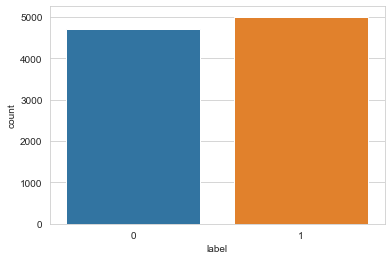

In [118]:
sns.set_style('whitegrid')
sns.countplot(x='label',data=visualize_label)

In [119]:
# Print the number of duplicated news in the dataframe

print("The total number of duplicated news are {:d} out of {:d}".
      format(news_df.count() - news_df.dropDuplicates(['text']).count(), news_df.count()))

The total number of duplicated news are 431 out of 9713


In [120]:
# Dropping duplicated news from "text" feature

news_df = news_df.dropDuplicates(["text"])

In [121]:
print("The total number of unique news in our dataset is: {:d}".format(news_df.count()))

The total number of unique news in our dataset is: 9282


### Text Preprocessing phase

    1.  Text cleaning 
    2.  Tokenization 
    3.  Stopwards removal
    4.  Stemming 

In [122]:
from pyspark.sql.functions import udf, col, lower, trim, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer

In [123]:
def text_preprocessing(df, column_name="content"):
   
    # Text Cleaning
    lower_case_news_df = df.withColumn(column_name, lower(col(column_name)))

    # Trimming the text
    trimmed_news_df = lower_case_news_df.withColumn(column_name, trim(col(column_name)))

    # Filtering out punctuations in the text
    no_punct_news_df = trimmed_news_df.withColumn(column_name, (regexp_replace(col(column_name), "[^a-zA-Z\\s]", "")))

    # Removing any extra whitespaces
    cleaned_news_df = no_punct_news_df.withColumn(column_name, trim(regexp_replace(col(column_name), " +", " ")))

    # Splitting text into tokens
    tokenizer = Tokenizer(inputCol=column_name, outputCol="tokens")
    tokens_df = tokenizer.transform(cleaned_news_df)

    # Removing Stopwords
    stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="terms")
    terms_df = stopwords_remover.transform(tokens_df)
   
    # Stemming words
    stemmer = SnowballStemmer(language="english")
    stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
    terms_stemmed_df = terms_df.withColumn("terms_stemmed", stemmer_udf("terms"))    
    
    return terms_stemmed_df

In [124]:
# Checking the type of our dataset

type(news_df)

pyspark.sql.dataframe.DataFrame

In [125]:
# Calling our text pre-processing function in order to apply it to the dataframe

transform_df = text_preprocessing(news_df, "text")

In [126]:
# Showing the transformations of the df after calling the above function

transform_df.show(n=10)

+--------------------+-----+--------------------+--------------------+--------------------+
|                text|label|              tokens|               terms|       terms_stemmed|
+--------------------+-----+--------------------+--------------------+--------------------+
|first lady melani...|    1|[first, lady, mel...|[first, lady, mel...|[first, ladi, mel...|
|donald trump is t...|    1|[donald, trump, i...|[donald, trump, t...|[donald, trump, t...|
|geneva reuters th...|    0|[geneva, reuters,...|[geneva, reuters,...|[geneva, reuter, ...|
|warsaw reuters po...|    0|[warsaw, reuters,...|[warsaw, reuters,...|[warsaw, reuter, ...|
|watch susan rice ...|    1|[watch, susan, ri...|[watch, susan, ri...|[watch, susan, ri...|
|can we just stop ...|    1|[can, we, just, s...|[stop, allowing, ...|[stop, allow, mus...|
|the entire nation...|    1|[the, entire, nat...|[entire, nation, ...|[entir, nation, w...|
|geneva reuters th...|    0|[geneva, reuters,...|[geneva, reuters,...|[geneva, r

### Feature Engineering Phase


In [127]:
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml import Pipeline

In [128]:
transform_df.columns

['text', 'label', 'tokens', 'terms', 'terms_stemmed']

In [129]:
from pyspark.sql.functions import size

count_df = transform_df.select('*',size('terms_stemmed').alias('length'))

In [130]:
count_df.show()

+--------------------+-----+--------------------+--------------------+--------------------+------+
|                text|label|              tokens|               terms|       terms_stemmed|length|
+--------------------+-----+--------------------+--------------------+--------------------+------+
|first lady melani...|    1|[first, lady, mel...|[first, lady, mel...|[first, ladi, mel...|   101|
|donald trump is t...|    1|[donald, trump, i...|[donald, trump, t...|[donald, trump, t...|   182|
|geneva reuters th...|    0|[geneva, reuters,...|[geneva, reuters,...|[geneva, reuter, ...|    72|
|warsaw reuters po...|    0|[warsaw, reuters,...|[warsaw, reuters,...|[warsaw, reuter, ...|    55|
|watch susan rice ...|    1|[watch, susan, ri...|[watch, susan, ri...|[watch, susan, ri...|   110|
|can we just stop ...|    1|[can, we, just, s...|[stop, allowing, ...|[stop, allow, mus...|   290|
|the entire nation...|    1|[the, entire, nat...|[entire, nation, ...|[entir, nation, w...|   206|
|geneva re

In [131]:
# convert to pandas to visualize the length of the documents

visualize_len = count_df.select("length").toPandas()

Text(0, 0.5, 'Frequency')

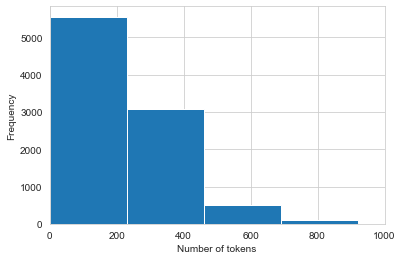

In [132]:
# histogram 

plt.xlim([0,1000])
plt.hist(visualize_len, bins=20)
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")

#### Application of Bag of Words and TF-IDF

In [133]:
def feature_extraction(df, column_name="terms_stemmed"):   
    
    cv = CountVectorizer(inputCol=column_name, outputCol="count_vectorizer", vocabSize=100, minDF=5)
    tf = IDF(inputCol="count_vectorizer", outputCol="tf_features")
    
    pipeline = Pipeline(stages=[cv,tf])
    features = pipeline.fit(df)
    tf_idf = features.transform(df)
    
    return tf_idf

In [134]:
features_tf_df = feature_extraction(transform_df)

In [135]:
# show the first 10 columns 

features_tf_df.show(10)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|label|              tokens|               terms|       terms_stemmed|    count_vectorizer|         tf_features|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|first lady melani...|    1|[first, lady, mel...|[first, lady, mel...|[first, ladi, mel...|(100,[0,1,4,10,15...|(100,[0,1,4,10,15...|
|donald trump is t...|    1|[donald, trump, i...|[donald, trump, t...|[donald, trump, t...|(100,[1,5,7,8,10,...|(100,[1,5,7,8,10,...|
|geneva reuters th...|    0|[geneva, reuters,...|[geneva, reuters,...|[geneva, reuter, ...|(100,[0,13,26,27,...|(100,[0,13,26,27,...|
|warsaw reuters po...|    0|[warsaw, reuters,...|[warsaw, reuters,...|[warsaw, reuter, ...|(100,[0,5,9,11,12...|(100,[0,5,9,11,12...|
|watch susan rice ...|    1|[watch, susan, ri...|[watch, susan

In [136]:
# display only the two last columns of the df

features_tf_df.select("count_vectorizer","tf_features").show(n=10)


+--------------------+--------------------+
|    count_vectorizer|         tf_features|
+--------------------+--------------------+
|(100,[0,1,4,10,15...|(100,[0,1,4,10,15...|
|(100,[1,5,7,8,10,...|(100,[1,5,7,8,10,...|
|(100,[0,13,26,27,...|(100,[0,13,26,27,...|
|(100,[0,5,9,11,12...|(100,[0,5,9,11,12...|
|(100,[0,1,4,8,11,...|(100,[0,1,4,8,11,...|
|(100,[2,3,7,9,14,...|(100,[2,3,7,9,14,...|
|(100,[1,3,4,7,8,9...|(100,[1,3,4,7,8,9...|
|(100,[0,3,8,10,12...|(100,[0,3,8,10,12...|
|(100,[0,2,6,13,16...|(100,[0,2,6,13,16...|
|(100,[0,2,3,10,13...|(100,[0,2,3,10,13...|
+--------------------+--------------------+
only showing top 10 rows



###  Model Training Phase

In [137]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import BinaryClassificationMetrics


#### Splitting the dataset into 2 parts, train and testing 80% and 20% respectively.


In [138]:
train_split_df, test_split_df = features_tf_df.randomSplit([0.8,0.2])


In [139]:
test_split_df.count()

1883

In [140]:
train_split_df.count()

7399

In [141]:
test_split_df.columns

['text',
 'label',
 'tokens',
 'terms',
 'terms_stemmed',
 'count_vectorizer',
 'tf_features']

#### Free some space in RAM

In [142]:
import gc

test_split_df = test_split_df.drop("tokens", "terms", "terms_stemmed", "count_vectorizer", "text")

print("Garbage collector: collected %d objects" % (gc.collect()))

Garbage collector: collected 215 objects


In [143]:
train_split_df = train_split_df.drop("tokens", "terms", "terms_stemmed", "count_vectorizer", "text")

print("Garbage collector: collected %d objects" % (gc.collect()))


Garbage collector: collected 41 objects


In [144]:
test_split_df.columns

['label', 'tf_features']

In [145]:
train_split_df.columns

['label', 'tf_features']

### Model  Functions / Automatization

#### Perform Cross-Validation 

In [146]:
def cross_valid(df, estimator, num_folds, param_name, param_values, evaluator):
    
    # ParamMap(s) — the list of parameters we want to evaluate to find the best model

    param_grid = ParamGridBuilder().baseOn({estimator.labelCol: 'label'}).baseOn([estimator.predictionCol, 'prediction'])
    
    for i in range(0, len(param_name)):
        param_grid = param_grid.addGrid(param_name[i], param_values[i])
        
    param_grid = param_grid.build()
    
    cv = CrossValidator(estimator=estimator,
                           estimatorParamMaps=param_grid,
                           evaluator= evaluator,
                           numFolds=num_folds, 
                           parallelism=2)
    
    training_model = cv.fit(df)
                                    
    
    return training_model
    

#### Function for Visualisation of ROC Curve

In [147]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

### Evaluate performance on train/test data - Visualisation
#### Automatization function

In [148]:
from pyspark.mllib.evaluation import MulticlassMetrics

def evaluate_performance(df, model):  
    
    best_model = model.bestModel
    
    # generate predictions
    label_predictions = best_model.transform(df)
    
    # convert from int to double - the method requirement
    label_predictions =  label_predictions.withColumn("label", label_predictions.label.cast('double'))
    label_predictions =  label_predictions.withColumn("prediction", label_predictions.prediction.cast('double'))

    metrics = MulticlassMetrics(label_predictions.select('prediction', 'label').rdd)
    print(metrics.confusionMatrix().toArray())
        
    print("Accuracy : ", metrics.accuracy)
    print("F1-score for class 0: ", metrics.fMeasure(0.0))
    print("F1-score for class 1: ", metrics.fMeasure(1.0))   
    
    evaluater = BinaryClassificationEvaluator(labelCol="label", metricName='areaUnderROC')
    print("AreaUnderROC: ", evaluater.evaluate(label_predictions))
    
    pred = label_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
    points = CurveMetrics(pred).get_curve('roc')

    plt.figure()
    x_val = [x[0] for x in points]
    y_val = [x[1] for x in points]
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(x_val, y_val)


## Logistic Regression

In [149]:
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import MulticlassMetrics

In [150]:
train_split_df.columns

['label', 'tf_features']

#### Setup Logistic regression 

In [151]:
log_reg = LogisticRegression(featuresCol="tf_features", labelCol='label')

In [152]:
param_names = [log_reg.regParam, log_reg.maxIter]
param_values = [[0.1, 0.01], [90, 110]]

ev = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")
log_reg_cv = cross_valid(df=train_split_df ,estimator=log_reg, num_folds=5, param_name=param_names, param_values=param_values,evaluator=ev)

In [153]:
log_reg_cv

CrossValidatorModel_7fc018c762ce

### Save Logistic Regression Model

In [154]:
log_reg_cv.bestModel.save("LogisticRegression")

#### Evaluate performance on Test Set

C:\Users\User\anaconda3\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[947.  15.]
 [  7. 914.]]
Accuracy :  0.9883165161975571
F1-score for class 0:  0.988517745302714
F1-score for class 1:  0.9881081081081081
AreaUnderROC:  0.9967889463003526


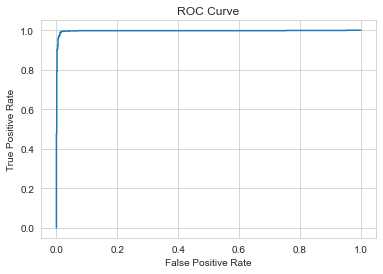

In [155]:
evaluate_performance_lr_testSet = evaluate_performance(df=test_split_df.limit(1905), model=log_reg_cv)

#### Evaluate performance on Train Set

[[3692.   31.]
 [  41. 3635.]]
Accuracy :  0.9902689552642249
F1-score for class 0:  0.990343347639485
F1-score for class 1:  0.9901934077907927
AreaUnderROC:  0.9971055655854548


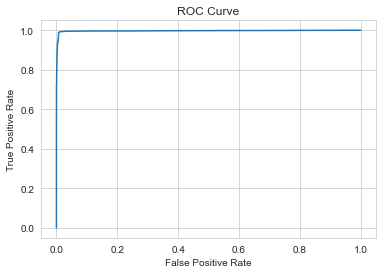

In [156]:
evaluate_performance_lr_trainSet = evaluate_performance(df=train_split_df.limit(train_split_df.count()), model=log_reg_cv)

#### Best tuned Hyper parameters

In [157]:
best_regParam = log_reg_cv.bestModel._java_obj.getRegParam()
best_maxIter = log_reg_cv.bestModel._java_obj.getMaxIter()

In [158]:
print("Best iteration value: ", best_maxIter)
print("Best regularization parameter value: ", best_regParam)

Best iteration value:  90
Best regularization parameter value:  0.01


## Random Forest Classifier

In [159]:
from pyspark.ml.classification import RandomForestClassifier

#### Setup Random Forest


In [160]:
rf = RandomForestClassifier(featuresCol="tf_features", labelCol='label')

In [161]:
param_names = [rf.maxDepth, rf.numTrees]
param_values = [[3, 6], [200, 300]]

ev = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")
cv_rf = cross_valid(df=train_split_df ,estimator=rf, num_folds=5, param_name=param_names, param_values=param_values,evaluator=ev)

###  Save Random Forest Model

In [162]:
cv_rf.bestModel.save("RandomForest")

#### Evaluate performance on Test Set

[[954.   8.]
 [  5. 916.]]
Accuracy :  0.9930961232076474
F1-score for class 0:  0.9932326913066111
F1-score for class 1:  0.9929539295392953
AreaUnderROC:  0.9987663684732095


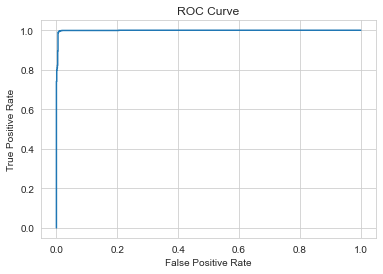

In [163]:
evaluate_performance_rf_testSet = evaluate_performance(df=test_split_df.limit(test_split_df.count()), model=cv_rf)

#### Evaluate performance on Train Set

[[3705.   18.]
 [  25. 3651.]]
Accuracy :  0.9941884038383565
F1-score for class 0:  0.9942305112035422
F1-score for class 1:  0.9941456773315182
AreaUnderROC:  0.9983505468608693


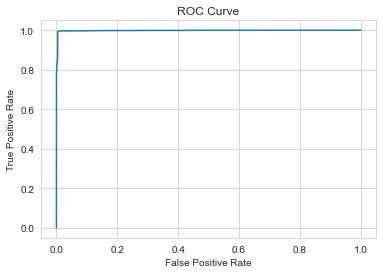

In [164]:
evaluate_performance_rf_trainSet = evaluate_performance(df=train_split_df.limit(train_split_df.count()), model=cv_rf)

#### Best tuned Hyper parameters

In [165]:
best_maxDepth = cv_rf.bestModel._java_obj.getMaxDepth()
best_numTrees = cv_rf.bestModel._java_obj.getNumTrees()

In [166]:
print("Best max depth value: ", best_maxDepth)
print("Best numberof trees : ", best_numTrees)

Best max depth value:  6
Best numberof trees :  200


## Multilayer Perceptron Model

In [167]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

#### Setup Multilayer Perceptron


In [168]:
mlp = MultilayerPerceptronClassifier(labelCol="label", predictionCol="prediction", featuresCol="tf_features")

In [169]:
param_names = [mlp.layers, mlp.stepSize]
param_values = [[[100, 5, 2], [100, 2, 2]], [0.01, 0.1]]

ev = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")
mlp_cv = cross_valid(df=train_split_df ,estimator=mlp, num_folds=5, param_name=param_names, param_values=param_values,evaluator=ev)

In [170]:
mlp_cv

CrossValidatorModel_ef43bf1b3c03

### Save Multilayer Perceptron Model

In [171]:
mlp_cv.bestModel.save("MultiLayerPerceptron")

#### Evaluate performance on Test Set

[[942.  20.]
 [ 11. 910.]]
Accuracy :  0.9835369091874668
F1-score for class 0:  0.9838120104438641
F1-score for class 1:  0.9832522960561858
AreaUnderROC:  0.997176078609303


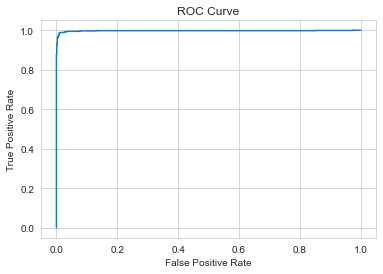

In [172]:
evaluate_performance_mlp_testSet = evaluate_performance(df=test_split_df.limit(test_split_df.count()), model=mlp_cv)

#### Evaluate performance on Train Set

[[3706.   17.]
 [  16. 3660.]]
Accuracy :  0.9955399378294364
F1-score for class 0:  0.9955674949630624
F1-score for class 1:  0.9955120359037127
AreaUnderROC:  0.9989597207255334


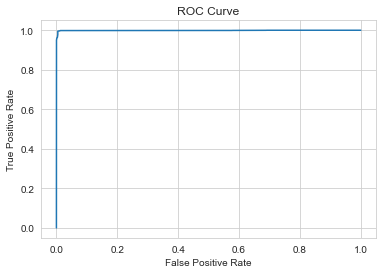

In [173]:
evaluate_performance_mlp_trainSet = evaluate_performance(df=train_split_df.limit(train_split_df.count()), model=mlp_cv)

In [174]:
best_alpha = mlp_cv.bestModel.getStepSize()
best_layer = mlp_cv.bestModel.getLayers()

In [175]:
print("Best layer", best_layer)
print("Best learning rate:", best_alpha)

Best layer [100, 2, 2]
Best learning rate: 0.01


### HuggingFace Transformer  

#### Load Dataset

In [14]:
from datasets import load_dataset

df = load_dataset("csv", data_files="news.csv")
df

Using custom data configuration default-c2673a6a464861ea
Reusing dataset csv (C:\Users\User\.cache\huggingface\datasets\csv\default-c2673a6a464861ea\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'subject', 'date', 'label'],
        num_rows: 44898
    })
})

#### Select first 10'000 shuffled training examples.

In [15]:
df = df['train'].shuffle().select(range(10000))
df

Dataset({
    features: ['title', 'text', 'subject', 'date', 'label'],
    num_rows: 10000
})

#### Split the original dataset. 
- 20% for Test Set and 80% Train Set 
- Apply shuffle technique to the dataset.
- Set Seed value to save the state of a random function to make sure we get the same training and validation data set while we use different hyperparameters or ml algorithms.

In [16]:
dataset = df.train_test_split(test_size=0.2, shuffle=True, seed=10)
dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'subject', 'date', 'label'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['title', 'text', 'subject', 'date', 'label'],
        num_rows: 2000
    })
})

#### Create separate train/test .csv files to train and test the model.

In [17]:
df_train = dataset['train'].to_pandas()
df_test = dataset['test'].to_pandas()
df_train.to_csv('train.csv', index=False)
df_test.to_csv('test.csv', index=False)

#### Split text into tokens

- We used 'base-bert-uncased' variant of pre-trained BERT model.
- We have set <i> truncation=True</i> and <i>padding</i> with the maximum length, so that we can get same length inputs for the model. If the text is long, then it will be truncated to 512 tokens, while the short texts will have extra tokens added to make it 512 tokens.

- 512 tokens is used because this is the maximum token length that the BERT model can take.



In [18]:
from transformers import AutoTokenizer

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding='max_length')

tokenized_datasets = dataset.map(tokenize_function, batched=True)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\User/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/re

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [19]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'subject', 'date', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['title', 'text', 'subject', 'date', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

#### Remove unimportant columns

In [20]:
tokenized_datasets = tokenized_datasets.remove_columns(column_names=['title', 'text', 'subject', 'date'])


#### After tokenizing the text, we get a python dictionary with 3 keys:

In [21]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

#### Sequence Classification Model

In [22]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\User/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-un

#### Define Training Arguments

In [23]:
from transformers import TrainingArguments
    
training_args = TrainingArguments(
    output_dir='model_results',          # output directory
    overwrite_output_dir=True,           # overwrite the output_dir if it exists
    num_train_epochs=1,                  # total number of training epochs
    learning_rate=2e-5,                  # set learning rate 
    per_device_train_batch_size=8,       # batch size per device during training
    per_device_eval_batch_size=8,        # batch size for evaluation
    warmup_steps=20,                     # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                   # strength of weight decay
    logging_dir=None,                    # directory for storing logs
    logging_steps=50,                    # nr of training/update sets to show logging
    evaluation_strategy='steps'
)

using `logging_steps` to initialize `eval_steps` to 50
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


#### Evaluate model - AUC score & F1-Score

In [24]:
from datasets import load_metric
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score

metric = load_metric("glue", "mrpc")

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    auc_score = roc_auc_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    return {'AUC SCORE' : auc_score, 'F1 SCORE' : f1}

#### Define Training

In [26]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics
)

trainer

#### Train pre-trained model

In [27]:
trainer.train()

***** Running training *****
  Num examples = 8000
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1000


Step,Training Loss,Validation Loss,Auc score,F1 score
50,0.401200,0.065084,0.994936,0.995247
100,0.030600,0.015547,0.996465,0.996671
150,0.018200,0.013467,0.997893,0.998101
200,0.048500,0.013619,0.997094,0.997140
250,0.012200,0.017956,0.996143,0.996183
300,0.004900,0.015848,0.996619,0.996662
350,0.000500,0.012246,0.997570,0.997618
400,0.017400,0.015866,0.997621,0.997616
450,0.000500,0.005751,0.998522,0.998572
500,0.000300,0.005346,0.998522,0.998572


***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
Saving model checkpoint to model_results\checkpoint-500
Configuration saved in model_results\checkpoint-500\config.json
Model weights saved in model_results\checkpoint-500\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
***** Running Evaluation *****
  Num exa

TrainOutput(global_step=1000, training_loss=0.030529380468651654, metrics={'train_runtime': 86667.9886, 'train_samples_per_second': 0.092, 'train_steps_per_second': 0.012, 'total_flos': 2104888442880000.0, 'train_loss': 0.030529380468651654, 'epoch': 1.0})

In [31]:
tokenized_datasets["train"].select(range(0,5))

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5
})

#### Perform prediction in the train set

In [176]:
predictions = trainer.predict(tokenized_datasets["train"])

***** Running Prediction *****
  Num examples = 8000
  Batch size = 8


In [177]:
predictions

PredictionOutput(predictions=array([[ 4.612679 , -4.67133  ],
       [-3.97607  ,  3.976919 ],
       [ 4.701001 , -4.7297363],
       ...,
       [-4.1095963,  4.1166973],
       [ 4.6605244, -4.704363 ],
       [ 4.63709  , -4.7067747]], dtype=float32), label_ids=array([0, 1, 0, ..., 1, 0, 0], dtype=int64), metrics={'test_loss': 0.0043039098381996155, 'test_AUC SCORE': 0.9990943336099185, 'test_F1 SCORE': 0.9991639794577809, 'test_runtime': 10989.7419, 'test_samples_per_second': 0.728, 'test_steps_per_second': 0.091})

#### Perform prediction in the test set

In [188]:
test_predictions = trainer.predict(tokenized_datasets["test"])

***** Running Prediction *****
  Num examples = 2000
  Batch size = 8


In [189]:
test_predictions

PredictionOutput(predictions=array([[-4.4944572,  4.4739933],
       [-4.4081397,  4.4146576],
       [-4.5356436,  4.5622034],
       ...,
       [ 4.718771 , -4.705    ],
       [ 4.6863885, -4.6990643],
       [ 4.6458483, -4.6729765]], dtype=float32), label_ids=array([1, 1, 1, ..., 0, 0, 0], dtype=int64), metrics={'test_loss': 0.004500946030020714, 'test_AUC SCORE': 0.9985216548241977, 'test_F1 SCORE': 0.9985721085197524, 'test_runtime': 3060.7679, 'test_samples_per_second': 0.653, 'test_steps_per_second': 0.082})

#### Preprocess raw predictions

- Define maximum value from a target function / find the class with the largest predicted probability.

In [178]:
preds = np.argmax(predictions.predictions, axis=-1)

In [179]:
preds

array([0, 1, 0, ..., 1, 0, 0], dtype=int64)

### Save Transformer Model

In [36]:
trainer.save_model(output_dir='TransformerModel') 

Saving model checkpoint to TransformerModel
Configuration saved in TransformerModel\config.json
Model weights saved in TransformerModel\pytorch_model.bin


In [180]:
checkpoint

'bert-base-uncased'

### Load the Transformer Model and use it

In [182]:
loaded_model = AutoModelForSequenceClassification.from_pretrained("TransformerModel", local_files_only=True)

loading configuration file TransformerModel\config.json
Model config BertConfig {
  "_name_or_path": "TransformerModel",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file TransformerModel\pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification

In [183]:
small_df = tokenized_datasets["train"].select(range(0,5))
small_df = small_df.remove_columns(column_names=['label'])
small_df
small_df

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5
})

#### Example with a single document

In [184]:
txt = ("Given the recent downturn in stocks especially in tech which is likely to persist as yields keep going up, "
       "I thought it would be prudent to share the risks of investing in ARK ETFs, written up very nicely by "
       "[The Bear Cave](https://thebearcave.substack.com/p/special-edition-will-ark-invest-blow). The risks comes "
       "primarily from ARK's illiquid and very large holdings in small cap companies. ARK is forced to sell its "
       "holdings whenever its liquid ETF gets hit with outflows as is especially the case in market downturns. "
       "This could force very painful liquidations at unfavorable prices and the ensuing crash goes into a "
       "positive feedback loop leading into a death spiral enticing even more outflows and predatory shorts.")

tokens = tokenizer.encode_plus(txt, truncation=True, padding='max_length', return_tensors='pt')

In [185]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [186]:
pred = loaded_model(**tokens)
pred.logits

tensor([[-3.9542,  3.9245]], grad_fn=<AddmmBackward0>)

In [187]:
import torch

torch.argmax(pred.logits).item()

1